<h1 align="center"><u><b> ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ ΚΑΙ ΕΥΦΥΗ ΥΠΟΛΟΓΙΣΤΙΚΑ ΣΥΣΤΗΜΑΤΑ</b></u></h1>

<h2 align="center"><u><b> Εργασία 3<sup>η</sup></h2>
<ul>
<li>Παναγιώτης Παπαδέας 03118039</li>

<li>Εμμανουήλ Βλάσσης 03118086</li>

<li>Λαουρεντιάν Γκούμε 03118014</li>
</ul>

<h2 align="center"><b><u> Πρώτο παραδοτέο (χωρίς βελτιώσεις) </u></b></h2>

### Σετάρισμα

<h4 align="justify"> Ξεκινάμε κατεβάζοντας και εισάγοντας τα κατάλληλα πακέτα: </h4>

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 17 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 11s (38.1 MB/s)
(Reading database ... 128208 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128175 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.

In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.8.2
    Uninstalling tensorflow-datasets-4.8.2:
      Successfully uninstalled tensorflow-datasets-4.8.2


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.2 MB/s eta 0:00:00


In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

### Κατέβασμα δεδομένων

<h4 align="justify"> Στα επόμενα 2 κελιά, κατεβάζουμε το zip με τις εικόνες, καθώς και τα αρχεία με τα captions, train και test csv αντίστοιχα:</h4>

In [ ]:
# Download image files

image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376381805/4376381805 [==============================] - 241s 0us/step


In [ ]:
# Download captions file

captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list

train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)


# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

66196/66196 [==============================] - 0s 2us/step


<h4 align="justify"> Με τον ακόλουθο κώδικα οργανώνουμε τα filenames και τα captions σε λίστες και καθιστούμε τα train και test sets επεξεργάσιμα: </h4>

In [ ]:
path="."

IMAGE_DIR="image_dir"

path = pathlib.Path(path)

   

captions = (path/captions_file).read_text().splitlines()

captions = (line.split('\t') for line in captions)

captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

   

cap_dict = collections.defaultdict(list)

for fname, cap in captions:
  
  cap_dict[fname].append(cap)

   

train_files = (path/train_files_list).read_text().splitlines()

train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]

   

test_files = (path/test_files_list).read_text().splitlines()

test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

   

train_raw = tf.data.experimental.from_list(train_captions)

test_raw = tf.data.experimental.from_list(test_captions)

<h4 align="justify"> Στη συνέχεια βλέπουμε τη μορφή του train set, καθώς και το πρώτο στοιχείο αυτού (image path/image captions):</h4>

In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


<h4 align="justify"> Στη συνέχεια ορίζουμε τις διαστάσεις κάθε εικόνας (224x224x3), καθώς και το μοντέλο MobileNetV3Small για image classification με τις κατάλληλες παραμέτρους. Οι παράμετροι αυτές, κατά σειρά καθορίζουν πως οι διαστάσεις του input θα είναι αυτές που ορίσαμε παραπάνω, πως θα αφαιρέσουμε το τελευταίο fully-connected layer του μοντέλου και πως τα δεδομένα εισόδου θα προεπεξεργαστούν από το μοντέλο. Τέλος, κάνουμε το μοντέλο μη trainable ώστε να μην ανανεώνουμε τα βάρη του μοντέλου κατά τη διάρκεια της εκπαίδευσης. </h4>

### Εξαγωγή χαρακτηριστικών εικόνων

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 [==============================] - 0s 0us/step


<h4 align="justify"> Με την παρακάτω συνάρτηση, μπορούμε να φορτώσουμε μια εικόνα και να προσαρμόσουμε τις διαστάσεις της κατάλληλα για είσοδο στο μοντέλο μας: </h4>

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

<h4 align="justify"> Για κάθε εικόνα της εισόδου μας επιστρέφεται ένα features map από το μοντέλο </h4>

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


<h4 align="justify"> Συνεχίζουμε στο preprocessing με την παρακάτω συνάρτηση, η οποία δέχεται ως όρισμα ένα string και μας επιστρέφει το string αυτό, αφού το έχει επεξεργαστεί κατάλληλα για να προχωρήσει στο tokenization: </h4>

### Σετάρισμα του tokenizer/vectorizer κειμένου

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

<h4 align="justify"> Ορίζουμε ένα TextVectorization layer το οποίο θα κάνει και το τελικό preprocessing προτού δώσει τα text data στο μοντέλο μας. Το επίπεδο αυτό χρησιμοποιεί τις πρώτες 5000 λέξεις από το λεξιλόγιο, κάνει ένα αρχικό preprocessing μέσω της standardize που ορίσαμε παραπάνω και επιτρέπει input tensors μεταβλητού μεγέθους. Μετά εφαρμόζουμε το layer αυτό στα δεδομένα εισόδου με την adapt.

In [ ]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<h4 align="justify"> Βλέπουμε τις πρώτες 10 λέξεις από το vocabulary, καθώς και μια εφαρμογή του tokenizer σε μια λίστα, που αποτελείεται από 2 υπο-λίστες:</h4>

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 755, 5, 2, 63, 4], [3, 2, 2866, 34, 4]]>

<h4 align="justify"> Το παρακάτω snippet, δημιουργεί 2 lookup tables με mappings μεταξύ λέξεων και των αντίστοιχων indices, χρησιμοποιώντας το λεξιλόγιο που μάθαμε από τον tokenizer. Στη συνέχεια, χρησιμοποιούμε το ένα εκ των δύο lookup tables (index to word) για να μετατρέψουμε το tokenized output που είδαμε παραπάνω, στις αρχικές λέξεις του vocabulary και τέλος κάνουμε join τα παραπάνω αποτελέσματα: </h4>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Προετοιμασία των Datasets

<h4 align="justify"> Τα dataset train_raw και test_raw περιέχουν 1:many (image, captions) ζευγάρια, οπότε η επόμενη συνάρτηση αντιγράφει την εικόνα, ώστε να έχουμε 1:1 αντιστοιχία. Στη συνέχεια, βλέπουμε τη συνάρτηση στην πράξη. </h4>

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


<h4 align="justify"> Για να είναι συμβατό με την εκπαίδευση του keras, το σύνολο δεδομένων θα πρέπει να περιέχει ζεύγη (inputs, labels). Για τη δημιουργία κειμένου, τα tokens είναι και είσοδος, αλλά και ετικέτες, μετατοπισμένες κατά ένα βήμα. Η επόμενη συνάρτηση μετατρέπει ένα ζευγάρι (images, texts) σε ένα ((images, input_tokens), label_tokens) ζευγάρι: </h4>

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

<h4 align="justify"> Η παρακάτω συνάρτηση προσθέτει λειτουργίες σε ένα dataset. Τα βήματα είναι τα εξής:

1. Φόρτωσε τις εικόνες (και αγνόησε τις εικόνες που αποτυγχάνουν να φορτωθούν).
2. Φτιάξε αντίγραφα των εικόνων, ώστε να αντιστοιχούν στο πλήθος των captions.
3. Ανακάτεψε και κάνε εκ νέου batch των ζευγαριών `image, caption`.
4. Κάνε tokenize το κείμενο, μετατόπισε τα tokens κατάλληλα και πρόσθεσε `label_tokens`.
5. Μετάτρεψε την μορφή του κειμένου από `RaggedTensor` σε padded dense `Tensor`.


In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

<h4 align="justify"> Με τον παρακάτω τρόπο εφαρμόζουμε τον feature extractor στο μοντέλο και εκπαιδευόμαστε στα datasets: </h4>

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Δεδομένα έτοιμα για εκπαίδευση

<h4 align="justify"> Το dataset επιστρέφει τώρα ζεύγη (input, label) κατάλληλα για εκπαίδευση με το Keras. Τα inputs είναι ζεύγη (images, input_tokens). Οι εικόνες έχουν επεξεργαστεί με το μοντέλο εξαγωγής χαρακτηριστικών. Για κάθε θέση στα input_tokens, το μοντέλο εξετάζει το κείμενο μέχρι στιγμής και προσπαθεί να προβλέψει το επόμενο, το οποίο βρίσκεται στην ίδια θέση στα labels: </h4>

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 22)
(32, 22)


<h4 align="justify"> Τα tokens εισόδου διαφέρουν από τις ετικέτες κατά μια μετατόπιση μιας θέσης.</h4>

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  29   5 148 139   2 295  80 294   5  39  11  41 150   0   0   0
   0   0   0   0]
[  2  29   5 148 139   2 295  80 294   5  39  11  41 150   4   0   0   0
   0   0   0   0]


### Είσοδος

<h4 align="justify"> Έχουμε ήδη χωρίσει το κείμενο εισόδου σε tokens και το έχουμε μετατρέψει σε sequences από IDs. 
To SeqEmbedding layer που ορίζουμε παρακάτω:
</h4>


 - Αναζητά το embedding vector για κάθε token.
 - Αναζητά το embedding vector για κάθε θέση της ακολουθίας.
 - Προσθέτει τα παραπάνω.
 - Αρχικοποιεί τα keras-masks για το μοντέλο με το mask_zero=True.



In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Αποκωδικοποιητής

<h4 align="justify">Ο αποκωδικοποιητής (decoder) είναι ένας κανονικός μετασχηματιστής-αποκωδικοποιητής και περιλαμβάνει μια στοίβα από DecoderLayers, όπου κάθε μια περιλαμβάνει τρια υπο-επίπεδα: μια CausalSelfAttention, μια CrossAttention, και μια FeedForward.</h4>

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

<h4 align="justify">Στη συνέχεια, τα τρία αυτά υπο-επίπεδα οργανώνονται σε ένα μεγαλύτερο DecoderLayer. Κάθε επίπεδο του αποκωδικοποιητή εφαρμόζει τα τρία μικρότερα layers με τη σειρά. Μετά από κάθε υπό-layer, η μορφή του out_seq είναι (batch, sequence, channels). Το επίπεδο του αποκωδικοποιητή επιστρέφει επίσης τα attention_scores για μετέπειτα οπτικοποιήσεις:</h4>

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Έξοδος

<h4 align="justify">
Κατ' ελάχιστο, το επίπεδο εξόδου απαιτεί ένα layers.Dense επίπεδο για να παράξει προβλέψεις για κάθε token σε κάθε θέση. Ωστόσο, προβαίνουμε στις παρακάτω βελτιστοποιήσεις:

1. Χειρισμός "κακών" tokens: Το μοντέλο παράγει κείμενο, οπότε δε θα έπρεπε να παράξει ποτέ pad, unknown, ή start token (`''`, `'[UNK]'`, 
   `'[START]'`). Οπότε ορίζουμε το bias αυτών σε μια μεγάλη αρνητική τιμή. Να σημειωθεί πως θα αγνοήσουμε τα tokens αυτά στην loss function επίσης.

2. Έξυπνη αρχικοποίηση: Η προεπιλεγμένη αρχικοποίηση ενός dense επιπέδου θα δώσει ένα μοντέλο που αρχικά προβλέπει κάθε token με σχεδόν ομοιόμορφη πιθανότητα. Η πραγματική κατανομή token απέχει πολύ από την ομοιόμορφη κατανομή. Η βέλτιστη τιμή για την αρχική παράμετρο πόλωσης της εξόδου είναι ο λογάριθμος της πιθανότητας κάθε token. Οπότε, συμπεριλαμβάνουμε μια μέθοδο adapt για να μετρήσουμε τα tokens και να ορίσουμε τη βέλτιστη αρχική παράμετρο πόλωσης. Αυτό μειώνει την αρχική απώλεια από την εντροπία της ομοιόμορφης κατανομής (log(vocabulary_size)) στην περιθωριακή εντροπία της κατανομής (-p*log(p)).





</h4>

In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


<h4 align="justify"> Η βελτιστοποιημένη αρχικοποίηση  μειώνει σημαντικά τις αρχικές απώλειες: </h4>

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3282it [02:17, 23.95it/s]


Uniform entropy: 8.52
Marginal entropy: 5.47


### Δημιουργία του μοντέλου

<h4 align="justify"> Για να δημιουργήσουμε το μοντέλο, απαιτείται ο συνδυασμός των κατωτέρω:

1. Ο εξαγωγέας χαρακτηριστικών εικόνων feature_extractor και ο text tokenizer.
2. Το επίπεδο seq_embedding, για να μετατρέψει συστάδες από token-IDs σε vectors (batch, sequence, channels).
3. Η στοίβα των DecoderLayers που θα επεξεργαστεί τα δεδομένα κειμένου και εικόνων.
4. Το επίπεδο εξόδου output_layer, το οποίο επιστρέφει πρόβλεψη για την επόμενη λέξη.
</h4>

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

<h4 align="justify"> Το μοντέλο, κατά την εκπαίδευσή του δέχεται ένα ζεύγος image,txt. Για να κάνουμε τη συνάρτησή μας λίγο πιο εύχρηστη όσον αφορά την είσοδο:

- Αν η εικόνα έχει 3 channels, την περνάμε μέσω του feature_extractor. Διαφορετικά θεωρούμε πως έχει ήδη γίνει.
- Αν ο τύπος του κειμένου είναι tf.string, το περνάμε από τον tokenizer

Μετά τα παραπάνω, η εκτέλεση του μοντέλου απαιτεί λίγα μόνο βήματα:

1. Κάνουμε flat τα εξαγόμενα από τις εικόνες χαρακτηριστικά, ώστε να αποτελέσουν είσοδο των decoder layers.
2. Αναζητούμε τα token embeddings.
3. Εκτελούμε τη στοίβα των DecoderLayers, στα χαρακτηριστικά των εικόνων και τα text embeddings.
4. Εκτελούμε το output layer για να προβλέψουμε το επόμενο token σε κάθε θέση.
</h4>

In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Παραγωγή captions

Πριν ξεκινήσουμε την εκπαίδευση, θα χρειαστεί να προετοιμάσουμε τον κώδικα που θα παράξει τα captions. Θα το χρησιμοποιήσουμε για να δούμε την πορεία της εκπαίδευσης. Ξεκινάμε κατεβάζοντας μια εικόνα:

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 1us/step


<h4 align="justify"> Για να βάλουμε caption σε μια εικόνα με το μοντέλο μας:

- Εξάγουμε τα img_features.
- Αρχικοποιούμε τη λίστα των tokens εξόδου με το [START] token.
- Περνάμε τα img_features, καθώς και τα tokens στο μοντέλο.
 - Επιστρέφει λίστα από logits.
 - Επιλέγει το επόμενο token βάσει των logits αυτών.
 - Πρόσθεσέ το στη λίστα των tokens και συνέχισε το loop.
 - Αν παραχθεί ένα [END] token, σταμάτα το loop.

Οπότε προσθέτουμε μία απλή μέθοδο για να κάνει τα παραπάνω: </h4>


In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

<h4 align="justify"> Παρακάτω βλέπουμε κάποια captions για την εικόνα αυτή, ωστόσο το μοντέλο δεν έχει εκπαιδευτεί ακόμα, οπότε και βλέπουμε ασυναρτησίες: </h4>

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a
a young a a a man two a



<h4 align="justify"> Η παράμετρος temperature που βλέπουμε παραπάνω επιλέγει μεταξύ 3 modes:

1. Greedy decoding (t = 0.0) - Επιλέγει το πιο πιθανό token σε κάθε βήμα.
2. Random sampling σύμφωνα με τα logits (t = 1.0).
3. Ομοιόμορφο random sampling (t >> 1.0).

</h4>

### Εκπαίδευση

<h4 align="justify"> Για να εκπαιδεύσουμε το μοντέλο θα χρειαστούμε διάφορα επιπρόσθετα τμήματα:

- Την απώλεια και μετρικές
- Τον Optimizer
- Προαιρετικά Callbacks
</h4>

### Απώλειες και μετρικές

<h4 align="justify">Υλοποιούμε την masked loss και το accuracy:

Κατά τον υπολογισμό της μάσκας της απώλειας, αξίζει να σημειώσουμε τη συνθήκη loss < 1e8, η οποία ουσιαστικά απορρίπτει τις απίθανα υψηλές απώλειες για τα banned tokens.</h4>

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

<h4 align="justify">Για ανατροφοδότηση κατά την εκπαίδευση, ορίζουμε ένα tf.keras.callbacks.Callback για να παράξουμε captions για την εικόνα που θέλουμε στο τέλος κάθε εποχής: </h4>

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a
man a a in a a a a a the a
tattoos cheerleaders are the at leather jeans



<h4 align="justify"> Χρησιμοποιούμε την callbacks.EarlyStopping για να τερματίσουμε την εκπαίδευση όταν το μοντέλο αρχίσει να κάνει overfit: </h4>

In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Εκπαίδευση
<h4 align="justify">Παραμετροποιούμε κατάλληλα και εκτελούμε την εκπαίδευση: </h4>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

<h4 align="justify">
Για να έχουμε συχνότερη εικόνα του τι γίνεται, χρησιμοποιούμε τη μέθοδο Dataset.repeat και ορίζουμε κατάλληλα τα steps_per_epoch και validation_steps.
Με το σετάρισμα αυτό, έχουμε reporting-epochs ανά 100 βήματα.
</h4>

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2242 - masked_acc: 0.1849

a man in a man in a man
a man in a man boy and woman
a picture sailing in a pink

100/100 [==============================] - 56s 353ms/step - loss: 5.2242 - masked_acc: 0.1849 - val_loss: 5.0086 - val_masked_acc: 0.2174
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.9033 - masked_acc: 0.2355

a man in a woman in a man
a man is with a woman
a shirt in the rock wearing a girl

100/100 [==============================] - 16s 156ms/step - loss: 4.9033 - masked_acc: 0.2355 - val_loss: 4.6969 - val_masked_acc: 0.2522
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.6623 - masked_acc: 0.2586

a man in a black shirt is in a red shirt is in the water
a man in a black shirt and the water
a is holding a park

100/100 [==============================] - 17s 167ms/step - loss: 4.6623 - masked_acc: 0.2586 - val_loss: 4.6039 - val_masked_acc: 0.2599
Epoch

<h4 align="justify"> Σχεδιάζουμε την απώλεια και το accuracy κατά την εκτέλεση εκπαίδευσης:
</h4>

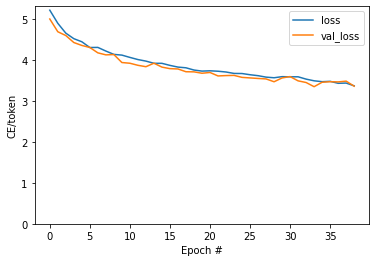

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

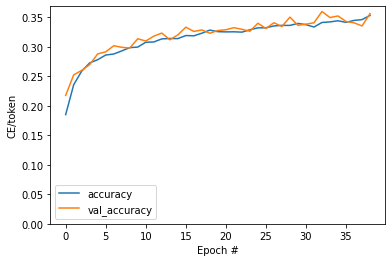

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Attention Plots

<h4 align="justify">Έχοντας το εκπαιδευμένο μοντέλο, εκτελούμε τη μέθοδο simple_gen στην εικόνα:</h4>

In [ ]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red shirt is swimming in a pool'

<h4 align="justify"> Splitάρουμε την έξοδο σε tokens: </h4>

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

<h4 align="justify">Τα DecoderLayers cachαρουν τα attention scores για το CrossAttention layer του καθενός. Η μορφή κάθε attention map είναι (batch = 1, heads, sequence, image). </h4>

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 12, 49]), TensorShape([1, 2, 12, 49])]

<h4 align="justify">
Στοιβάζουμε τα maps κατά τον batch άξονα, μετά παίρνουμε το average κατά τους άξονες (batch, heads), ενώ σπάμε τον άξονα image ξανά σε height, width.
</h4>

In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

<h4 align="justify">Τώρα έχουμε ένα μοναδικό attention map για κάθε sequence που προβλέψαμε. Οι τιμές σε κάθε map πρέπει να αθροίζουν στο 1:</h4>

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)>

<h4 align="justify"> Μπορούμε τώρα να δούμε που εστίαζε την προσοχή του κάθε φορά το μοντέλο, καθώς παρήγαγε κάθε token της εξόδου:
</h4>

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

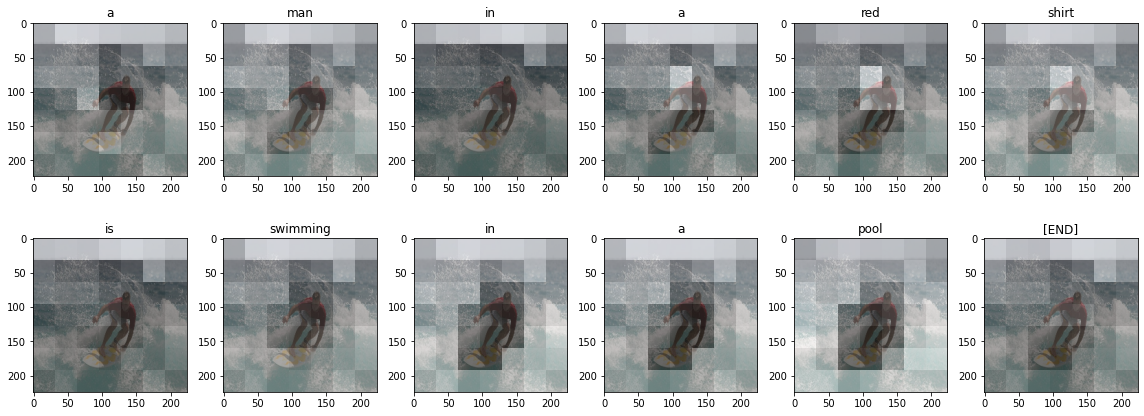

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

<h4 align="justify"> Αξιοποιούμε την παραπάνω συνάρτηση ως μέρος μιας πιο χρήσιμης συνάρτησης:
</h4>

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

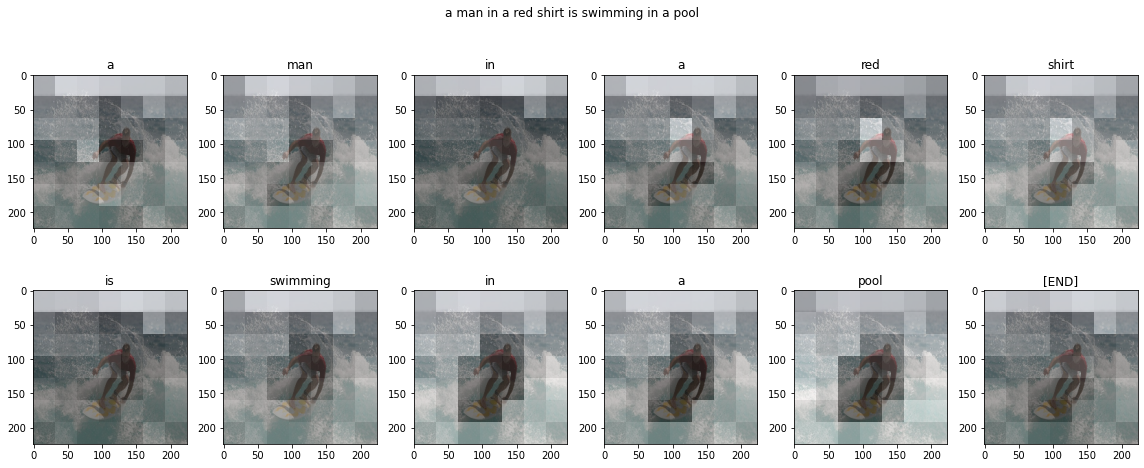

In [ ]:
run_and_show_attention(model, image)

<h4 align="justify"> Στη συνέχεια επιλέγουμε τυχαία μία εικόνα της επιλογής μας και εκτελούμε το ίδιο με πάνω: </h4>

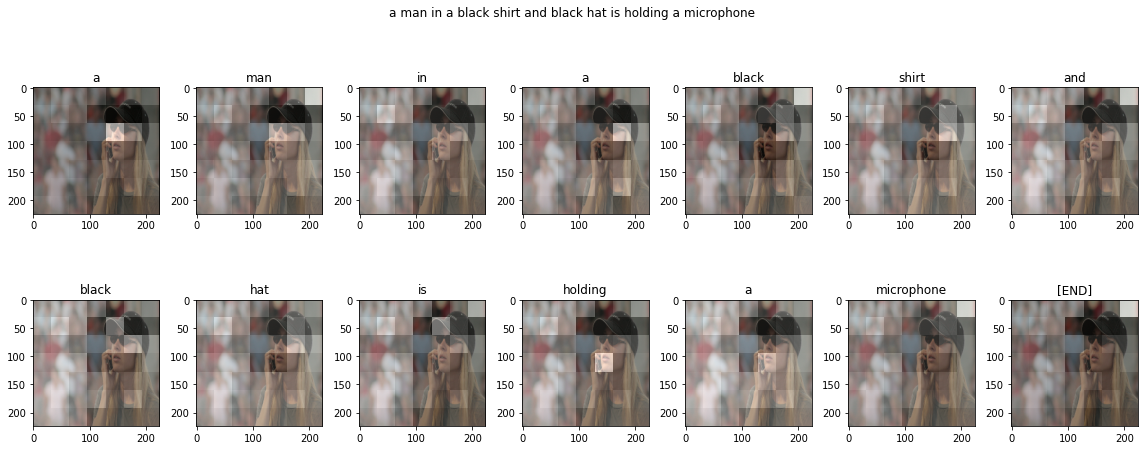

In [ ]:
image_url = 'image_dir/'+test_files[170]
#image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_url)

run_and_show_attention(model, image)

In [ ]:
print (cap_dict[test_files[170]])

['A young blond woman wearing a hat and sunglasses talks on her cellphone .', 'woman with dark glasses and ball cap talking on a cellphone', 'A blond woman in sunglasses and hat talks on a cellphone .', 'a lady with a baseball cap on talking on he cellphone', 'A woman talks on the phone at a stadium .']


### Αξιολόγηση της ποιότητας του captioning (BLEU)

<h4 align="justify">Υλοποιούμε παρακάτω τις συναρτήσεις για τον υπολογισμό των sentence_bleu και corpus_blue και τυπώνουμε τα αποτελέσματα αυτών: </h4>

In [ ]:
import nltk
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
def sent_bleu(img):
  references = cap_dict[img]
  image = load_image('image_dir/'+img)
  hypothesis = (model.simple_gen(image, temperature = 0.0)).split()
  ref_fin = []
  for ref in references:
    ref_fin.append(ref.split()) 
  score = nltk.translate.bleu_score.sentence_bleu(ref_fin, hypothesis, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)
  print('The sentence BLEU score is: ', score)

sent_bleu(test_files[170])  

The sentence BLEU score is:  0.039992426007770324


In [ ]:
def cop_bleu():
  ref_total = []
  hyp_fin = []
  for i in range(1000):
    ref_fin = []
    references = cap_dict[test_files[i]]
    image = load_image('image_dir/'+test_files[i])  
    hypothesis = (model.simple_gen(image, temperature=0.0)).split()  
    for ref in references:
      ref_fin.append(ref.split())
    ref_total.append(ref_fin)  
    hyp_fin.append(hypothesis) 
  score = nltk.translate.bleu_score.corpus_bleu(ref_total, hyp_fin, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)
  print('The corpus BLEU score for 1000 images is: ', score)   

cop_bleu()


      

The corpus BLEU score for 1000 images is:  0.18041148729050172


<h4 align="justify"> 
<i><u> ΣΗΜΕΙΩΣΗ:</u></i>  Να σημειωθεί πως η παράλειψη του προαιρετικού τμήματος όπου στο tutorial γίνεται caching των image features, έχει προκαλέσει διάφορες μικροαλλαγές στην δική μας έκδοση, κάποιες εκ των οποίων επηρεάζουν τα αποτελέσματά μας για αυτό και εμφανίζεται διαφορετικό caption για την εικόνα του surfer σε σχέση με την αναγραφόμενη στο documentation.
</h4>

<h2 align="center"><b><u> Δεύτερο παραδοτέο (με βελτιώσεις) </u></b></h2>

<h4 align="justify">Ξεκινάμε και εδώ με το κατέβασμα και την εισαγωγή των κατάλληλων βιβλιοθηκών, το κατέβασμα των δεδομένων και την κατάλληλη μορφοποίηση αυτών, όπως στο πρώτο μέρος:</h4>

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 17 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (53.0 MB/s)
(Reading database ... 128208 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128175 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.7

In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.8.2
    Uninstalling tensorflow-datasets-4.8.2:
      Successfully uninstalled tensorflow-datasets-4.8.2


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.7 MB/s eta 0:00:00


In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

In [ ]:
# Download image files

image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376381805/4376381805 [==============================] - 96s 0us/step


In [ ]:
# Download captions file

captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list

train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)


# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

66196/66196 [==============================] - 0s 1us/step


In [ ]:
path="."

IMAGE_DIR="image_dir"

path = pathlib.Path(path)

   

captions = (path/captions_file).read_text().splitlines()

captions = (line.split('\t') for line in captions)

captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

   

cap_dict = collections.defaultdict(list)

for fname, cap in captions:
  
  cap_dict[fname].append(cap)

   

train_files = (path/train_files_list).read_text().splitlines()

train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]

   

test_files = (path/test_files_list).read_text().splitlines()

test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

   

train_raw = tf.data.experimental.from_list(train_captions)

test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


<h4 align="justify">Μια επισκόπηση των captions που αναφέρονται στις 30 πρώτες εικόνες:</h4>

In [ ]:
count = 1
for keys, values in cap_dict.items():
  if (count == 30):
    break
  print (values)
  count = count+1

['A little girl holds orange lilies while others celebrate an occasion in a garden setting .', 'A little girl at a wedding holds a bouquet of orange flowers .', 'Young girl in orange dress holding orange flowers .', 'a girl at a wedding holding some orange flowers', 'A girl holds a bouquet of flowers']
['A young child walks down a gravel path lined with a row of red outdoor chairs .', 'A racetrack with red chairs stacked beside fence with a child walking .', 'A child in a striped shirt walks by some red chairs .', 'A child walking and leaving a trail behind them .', 'A little kid is walking next to red banners .']
['A woman wearing a green and white shirt and a cap is smiling , while another woman wearing a gray shirt and white cap is facing her .', 'A green sign in several languages mentions Facebook and Twitter , while people talk below in the sunlight .', 'A group of people are spreading the word about their organization using a piece green construction paper .', 'A woman shakes han

### Επιλογή Encoder
Από τα μοντέλα του Keras επιλέγουμε το [EfficientNetB3](https://keras.io/api/applications/efficientnet/#efficientnetb3-function). Ο συγκεκριμένος encoder δεν απαιτεί συγκεκριμένο input_shape, αρκεί να είναι ένα tuple από 3 τιμές, οπότε εμείς κρατάμε το IMAGE_SHAPE που είχε και το tutorial.

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.EfficientNetB3(
    input_shape=IMAGE_SHAPE,
    include_top=False)
mobilenet.trainable=False

43941136/43941136 [==============================] - 2s 0us/step


### Φόρτωση εικόνας
<h4 align="justify">Ορίζουμε μια συνάρτηση load_image(image_path) που διαβάζει μια εικόνα, και την κάνει resize στο μέγεθος που θέλουμε:</h4>

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 1536)


### Προεπεξεργασία Κειμένου
<h4 align="justify">Για να μελετήσουμε αν μπορούμε να χρησιμοποιήσουμε κάποιο εύρος για το μήκος των captions, φτιάχνουμε ένα ιστόγραμμα που δείχνει το πλήθος των captions συγκεκριμένου μεγέθους.</h4>

<h4 align="justify">Σημειώνουμε ότι σε κάθε caption αφαιρούμε την τελεία στο τέλος της πρότασης. </h4>

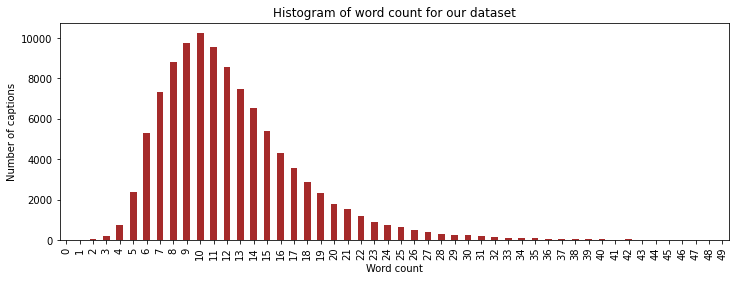

In [ ]:
from matplotlib import cm

# Create a histogram that shows the number of captions that have a specific word length
histogram = np.zeros(80, 'int')
for i in range(len(train_captions)):
    for j in range(len(train_captions[i][1])):
      caption_length = len(train_captions[i][1][j].split(" "))-1 # Remove the dot '.' at the end
      # of each caption
      histogram[caption_length] += 1 # Increase the frequency of that word count by 1

df = pd.DataFrame(histogram[:50]) 
plot_title = "Histogram of word count for our dataset"
df.plot(kind='bar', stacked=False, color="brown",
        title=plot_title, legend=False, figsize=(12, 4), ylabel="Number of captions", xlabel="Word count")
plt.show()

<h4 align="justify">Στη συνέχεια, αφαιρούμε από τη λίστα με τα image captions όσα captions είναι εκτός του επιθυμητού μας εύρους. Δημιουργούμε για τον σκοπό αυτό μια νέα λίστα, την train_captions_new, η οποία περιέχει μόνο τα επιθυμητά captions, εντός δηλαδή του εύρους μεταξύ min και max:</h4>

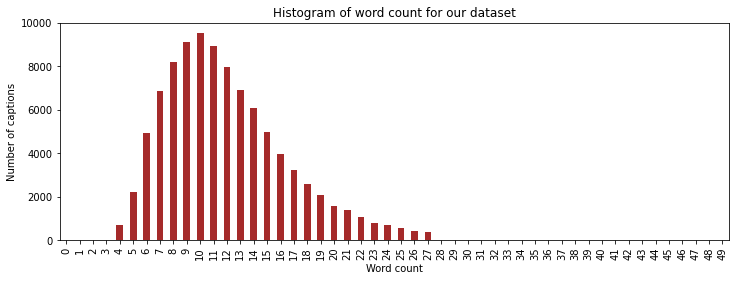

We removed 2002 images from our dataset


In [ ]:
# Remove all captions that are not in this range
train_captions_new = []
_min_ = 5 # Also count the '.'
_max_ = 28 # Also count the '.'

# Remove images that have at least one caption outside of thr caption legth window 
for i in range(len(train_captions)):
    captions = []
    for j in range(len(train_captions[i][1])):
      caption_length = len(train_captions[i][1][j].split(" "))
      if (caption_length >= _min_ and caption_length <= _max_):
        captions.append(train_captions[i][1][j])
      else:
        break
    if (len(captions) == 5):
      train_captions_new.append((train_captions[i][0], captions))

# Replot the histogram
histogram = np.zeros(80, 'int')
for i in range(len(train_captions_new)):
    for j in range(len(train_captions_new[i][1])):
      caption_length = len(train_captions_new[i][1][j].split(" "))-1 # Remove the dot '.' at the end
      # of each caption
      histogram[caption_length] += 1 # Increase the frequency of that word count by 1

df = pd.DataFrame(histogram[:50]) 
plot_title = "Histogram of word count for our dataset"
df.plot(kind='bar', stacked=False, color="brown",
        title=plot_title, legend=False, figsize=(12, 4), ylabel="Number of captions", xlabel="Word count")
plt.show()

train_raw = tf.data.experimental.from_list(train_captions_new)
num_images_removed = len(train_captions) - len(train_captions_new)
print("We removed " + str(num_images_removed) + " images from our dataset")

### Σετάρισμα του tokenizer/vectorizer κειμένου

<h4 align="justify"> Όπως και στο πρώτο μέρος, μετατρέπουμε όλα τα γράμματα σε πεζά και αφαιρούμε τα σημεία στίξης ή άλλους χαρακτήρες διαφυγής. Κάνουμε append σε κάθε caption τα "[START]" στην αρχή και "[END]" στο τέλος. </h4>

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

<h4 align="justify"> Συνεχίζουμε όπως και στο πρώτο μέρος με το TextVectorization layer, αλλά με διαφορετικό μέγεθος λεξιλογίου, ορισμένο στα 4000.</h4>

In [ ]:
# Use the top 4000 words for a vocabulary.
vocabulary_size = 4000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<h4 align="justify"> Βλέπουμε και πάλι τις πρώτες 10 λέξεις από το vocabulary, καθώς και μια εφαρμογή του tokenizer σε μια λίστα, που αποτελείεται από 2 υπο-λίστες:</h4>

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'man', 'and']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 777, 5, 2, 66, 4], [3, 2, 2647, 29, 4]]>

<h4 align="justify"> Όπως και στο πρώτο μέρος, δημιουργούμε 2 lookup tables με mappings μεταξύ λέξεων και των αντίστοιχων indices, χρησιμοποιώντας το λεξιλόγιο που μάθαμε από τον tokenizer. Στη συνέχεια, χρησιμοποιούμε το ένα εκ των δύο lookup tables (index to word) για να μετατρέψουμε το tokenized output που είδαμε παραπάνω, στις αρχικές λέξεις του vocabulary και τέλος κάνουμε join τα παραπάνω αποτελέσματα: </h4>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Προετοιμασία των Datasets

<h4 align="justify"> Φτιάχνουμε όπως και πριν την αντιστοιχία image ανά caption σε 1 προς 1: </h4>

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


<h4 align="justify"> Για λόγους συμβατότητας, μετατρέπουμε πάλι κάθε ζευγάρι (images, texts) σε ((images, input_tokens), label_tokens): </h4>

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

<h4 align="justify"> Επαναλαμβάνουμε τα βήματα προετοιμασίας των datasets: </h4>

1. Φόρτωσε τις εικόνες (και αγνόησε τις εικόνες που αποτυγχάνουν να φορτωθούν).
2. Φτιάξε αντίγραφα των εικόνων, ώστε να αντιστοιχούν στο πλήθος των captions.
3. Ανακάτεψε και κάνε εκ νέου batch των ζευγαριών `image, caption`.
4. Κάνε tokenize το κείμενο, μετατόπισε τα tokens κατάλληλα και πρόσθεσε `label_tokens`.
5. Μετάτρεψε την μορφή του κειμένου από `RaggedTensor` σε padded dense `Tensor`.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

<h4 align="justify">Εφαρμόζουμε τον encoder:</h4>

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Δεδομένα έτοιμα για εκπαίδευση

<h4 align="justify"> Έχουμε πλέον την κατάλληλη μορφή (input, label) για να ξεκινήσουμε το training, όπως είδαμε και στο πρώτο μέρος.</h4>

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 23)
(32, 23)


In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3  14  21  48 391   2 621  56 259 144   0   0   0   0   0   0   0   0
   0   0   0   0   0]
[ 14  21  48 391   2 621  56 259 144   4   0   0   0   0   0   0   0   0
   0   0   0   0   0]


### Είσοδος (Embeddings)

#### Επιλέγουμε να αξιοποιήσουμε τα embeddings "glove-wiki-gigaword-300" από το [Gensim](https://radimrehurek.com/gensim/models/word2vec.html). Σε σύγκριση με τα embeddings "glove-wiki-gigaword-100" και "glove-wiki-gigaword-200", το "glove-wiki-gigaword-300" είχε καλύτερα αποτελέσματα χωρίς σημαντική αύξηση του χρόνου εκπαίδευσης.

In [ ]:
import gensim.downloader

class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()

    # Το μοντέλο που επιλέξαμε
    embed_model = gensim.downloader.load('glove-wiki-gigaword-300')

    embedding_dim = 300
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for idx, word in enumerate(tokenizer.get_vocabulary()):
        try:
            embedding_vector = embed_model[word]
            embedding_matrix[idx] = embedding_vector
        except KeyError:
            vec = np.zeros(embedding_dim)
            embedding_matrix[idx] = vec
        
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
    
    self.token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                     output_dim=embedding_dim,
                                                     weights=[embedding_matrix],
                                                     trainable=False)
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Αποκωδικοποιητής

<h4 align="justify">Ορίζουμε ξανά την αλληλουχία των DecoderLayers που θα χρησιμοποιήσουμε, CausalSelfAttention, CrossAttention και FeedForward: </h4>

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

<h4 align="justify">Συνδυάζουμε τα παραπάνω υποεπίπεδα σε ένα DecoderLayer:</h4>

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Έξοδος

<h4 align="justify">Επαναλαμβάνουμε τις βελτιστοποιήσεις που κάναμε και στο πρώτο μέρος για το επίπεδο εξόδου, μειώνοντας σημαντικά τις απώλειες:</h4>

In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

2969it [02:35, 19.08it/s]


Uniform entropy: 8.29
Marginal entropy: 5.41


### Δημιουργία του μοντέλου

<h4 align="justify"> Για να δημιουργήσουμε το μοντέλο, απαιτείται ο συνδυασμός των κατωτέρω:

1. Ο εξαγωγέας χαρακτηριστικών εικόνων feature_extractor και ο text tokenizer.
2. Το επίπεδο seq_embedding, για να μετατρέψει batches από token-IDs σε vectors (batch, sequence, channels).
3. Η στοίβα των DecoderLayers που θα επεξεργαστεί τα δεδομένα κειμένου και εικόνων.
4. Το επίπεδο εξόδου output_layer, το οποίο επιστρέφει πρόβλεψη για την επόμενη λέξη.
</h4>

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=300, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

<h4 align="justify">  Προσθέτουμε κάποιες επιπλέον μεθόδους στην συνάρτηση εισόδου μας, για να τη βελτιώσουμε. Επαναλαμβάνουμε συνοπτικά για χάριν ευκολίας τις ενέργειες που κάνουμε: </h4>

- Αν η εικόνα έχει 3 channels, την περνάμε μέσω του feature_extractor. Διαφορετικά θεωρούμε πως έχει ήδη γίνει.
- Αν ο τύπος του κειμένου είναι tf.string, το περνάμε από τον tokenizer

<h4 align="justify">Πλέον η εκτέλεση του μοντέλου απαιτεί μόνο τα παρακάτω:

1. Κάνουμε flat τα εξαγόμενα από τις εικόνες χαρακτηριστικά, ώστε να αποτελέσουν είσοδο των decoder layers.
2. Αναζητούμε τα token embeddings.
3. Εκτελούμε τη στοίβα των DecoderLayers, στα χαρακτηριστικά των εικόνων και τα text embeddings.
4. Εκτελούμε το output layer για να προβλέψουμε το επόμενο token σε κάθε θέση.
</h4>

In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

## Υπερπαράμετροι του decoder
<h4 align="justify"> Αλλάξαμε την υπερπαράμετρο "units" από 256 σε 300 για να ταυτίζεται με τη διάσταση του embedding που χρησιμοποιούμε.
Όσον αφορά το dropout_rate, δεν παρατηρήσαμε κάποια αλλαγή μεταβάλλοντάς το λίγο. </h4>

In [ ]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=300, dropout_rate=0.5, num_layers=2, num_heads=2)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 2us/step


<h4 align="justify">Στο σημείο αυτό, θέλουμε το μοντέλο μας να μπορεί να περιγράφει κατάλληλα μια εικόνα, οπότε και προσθέτουμε μια μέθοδο που να κάνει τις παρακάτω ενέργειες: </h4>

- Εξάγουμε τα img_features.
- Αρχικοποιούμε τη λίστα των tokens εξόδου με το [START] token.
- Περνάμε τα img_features, καθώς και τα tokens στο μοντέλο.
 - Επιστρέφει λίστα από logits.
 - Επιλέγει το επόμενο token βάσει των logits αυτών.
 - Πρόσθεσέ το στη λίστα των tokens και συνέχισε το loop.
 - Αν παραχθεί ένα [END] token, σταμάτα το loop.

In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

### Beam Search

#### Αντί για την greedy αναζήτηση της επόμενης λέξης, φτιάχνουμε μια μέθοδο beam_gen που σε κάθε βήμα κρατάει τις καλύτερες προτάσεις (δηλαδή τις προτάσεις με τη μεγαλύτερη πιθανότητα). Βασιζόμαστε στη λογική από [εδώ](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24). 
(Επεξήγηση του κώδικα δίνεται σε σχόλια)

In [ ]:
@Captioner.add_method
def beam_gen(self, image, beam_size=5): # Implements beam search
  initial = self.word_to_index([['[START]']]) # (batch, sequence) όπως και στο simple_gen
  img_features = self.feature_extractor(image[tf.newaxis, ...])
  tokens_list = [(initial, 0.0)]  # list of (sequence, probabilities) 
  final_tokens_list = [] # list of (sequence, probabilities)

  remaining_beam_size = beam_size                 
  for n in range(50):
    if remaining_beam_size == 0:
      break
    new_tokens_list = []                          
    for tokens, prob in tokens_list:              
      if tokens[0][-1] == self.word_to_index('[END]'):
        remaining_beam_size -= 1
        final_tokens_list.append((tokens, prob))
        continue
        
      preds = self((img_features, tokens)).numpy()    # gen probabilities
      preds = preds[:, -1, :]                         
      top_b_preds = tf.math.top_k(preds, k=remaining_beam_size) # get the top k words
      top_b_tokens = top_b_preds.indices # tokens 
      top_b_prob = top_b_preds.values # probabilities

      for i in range(remaining_beam_size):
        next_token = [[top_b_tokens[0][i]]] # next token to be added to the sentence (in one branch)
        new_tokens = tf.concat([tokens, next_token], axis=1)
        new_log_prob = prob + top_b_prob[0][i]  # We use logarithms, so we add the probabilities together
        new_tokens_list.append((new_tokens, new_log_prob))
      
    tokens_list = sorted(new_tokens_list, key=lambda x: -x[1])[:remaining_beam_size] # Sort the list with b*b sentences and keep the first b

  # We also divide by the sentence length to get the sequence with the highest probability
  tokens, prob = max(final_tokens_list, key=lambda x: x[1]/len(x[0][0, 1:-1]))

  # Don't forget to convert back to actual words!
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  
  return result.numpy().decode()

### Απώλειες και μετρικές

<h4 align="justify">Υλοποιούμε την masked loss και το accuracy:</h4>

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

<h4 align="justify"> Ορίζουμε ένα tf.keras.callbacks.Callback, ώστε να λαμβάνουμε feedback στο τέλος κάθε εποχής όσον αφορά την εκπαίδευση για την παραγωγή captions </h4>

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.beam_gen(self.image, beam_size=5)
      print(result)
    print()

<h4 align="justify"> Βλέπουμε τα σαφώς καλύτερα αποτελέσματα της beam search σε σχέση με αυτά του πρώτου μέρους: </h4>

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a man in a red shirt is standing in the water
a man in a red shirt is standing in the water
a man in a red shirt is standing in the water



<h4 align="justify"> Με το παρακάτω τμήμα αποτρέπουμε το Overfitting: </h4>

In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Εκπαίδευση

<h4 align="justify">Αφού ορίσουμε τις κατάλληλες παραμέτρους, εκκινούμε την εκπαίδευση. </h4>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 3.9703 - masked_acc: 0.3131

a man in a red shirt is running through the water
a man in a red shirt is running through the water
a man in a red shirt is running through the water

100/100 [==============================] - 64s 407ms/step - loss: 3.9703 - masked_acc: 0.3131 - val_loss: 3.9262 - val_masked_acc: 0.3129
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 3.9207 - masked_acc: 0.3159

a man in a blue shirt is running through the water
a man in a blue shirt is running through the water
a man in a blue shirt is running through the water

100/100 [==============================] - 39s 387ms/step - loss: 3.9207 - masked_acc: 0.3159 - val_loss: 3.8099 - val_masked_acc: 0.3290
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 3.9138 - masked_acc: 0.3157

a man in a blue shirt is standing in the water
a man in a blue shirt is standing in the water
a man in a blue shirt is 

<h4 align="justify"> Οπτικοποιούμε την απώλεια και το accuracy κατά την εκτέλεση της εκπαίδευσης. Παρατηρούμε βελτίωση σε σχέση με το πρώτο μέρος, καθώς οι τιμές απώλειας είναι μικρότερες, ενώ οι τιμές accuracy μεγαλύτερες. Ωστόσο, αξίζει να σημειωθεί πως η μεγαλύτερη διαφορά βρίσκεται στην αρχή της εκαπίδευσης, καθώς στο τέλος αυτής δε φαίνεται να υπάρχει ιδιαίτερη απόκλιση μεταξύ των 2 μοντέλων.
</h4>

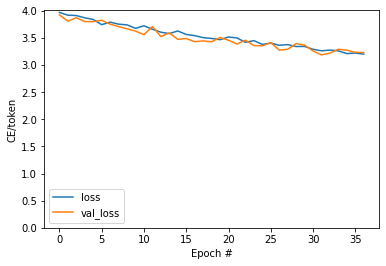

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

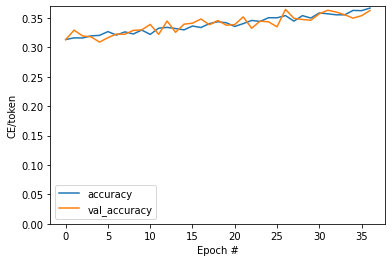

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Attention Plots

<h4 align="justify">Βλέπουμε το caption που παράγει το μοντέλο μας για την εικόνα του σέρφερ. </h4>

In [ ]:
result = model.beam_gen(image, beam_size=5)
result

'a man in a red shirt is jumping into the water'

<h4 align="justify"> Σπάμε την έξοδο σε tokens: </h4>

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

<h4 align="justify">Όπως και πριν, τα DecoderLayers cachαρουν τα attention scores για το CrossAttention layer του καθενός. Η μορφή κάθε attention map είναι (batch = 1, heads, sequence, image). </h4>

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 15, 49]), TensorShape([1, 2, 15, 49])]

<h4 align="justify">
Στακάρουμε τα maps κατά τον batch άξονα, μετά παίρνουμε το average κατά τους άξονες (batch, heads), ενώ σπάμε τον άξονα image ξανά σε height, width, όπως είδαμε και στο πρώτο μέρος:
</h4>

In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

<h4 align="justify">Έχουμε πλέον μοναδικό attention map ανά προβλεπόμενο sequence, οπότε και οι τιμές σε κάθε map πρέπει να έχουν άθροισμα άσσο.</h4>

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

<h4 align="justify">Ορίζουμε τη συνάρτηση που μας επιτρέπει να δούμε που εστίασε την προσοχή του το μοντέλο κατά τη διάρκεια της εκπαίδευσης P</h4>

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

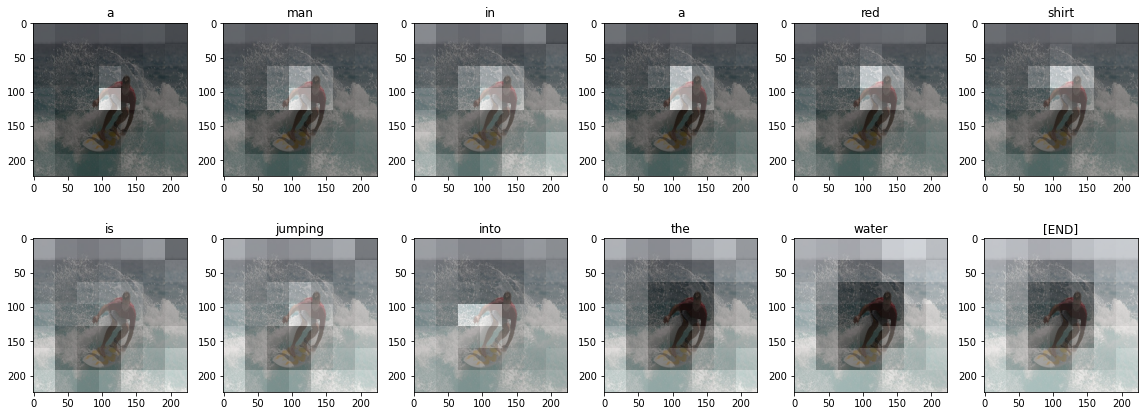

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

<h4 align="justify">
Ορίζουμε για λόγους ευχρηστίας μια νέα συνάρτηση, μέρος της οποίας αποτελεί η προηγούμενη. Παρατηρούμε πως παράμετρο της συνάρτησης αποτελεί το beam_size, αντί του temperature που είχαμε προηγουμένως.
</h4>

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, beam_size=5):
  result_txt = self.beam_gen(image, beam_size)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

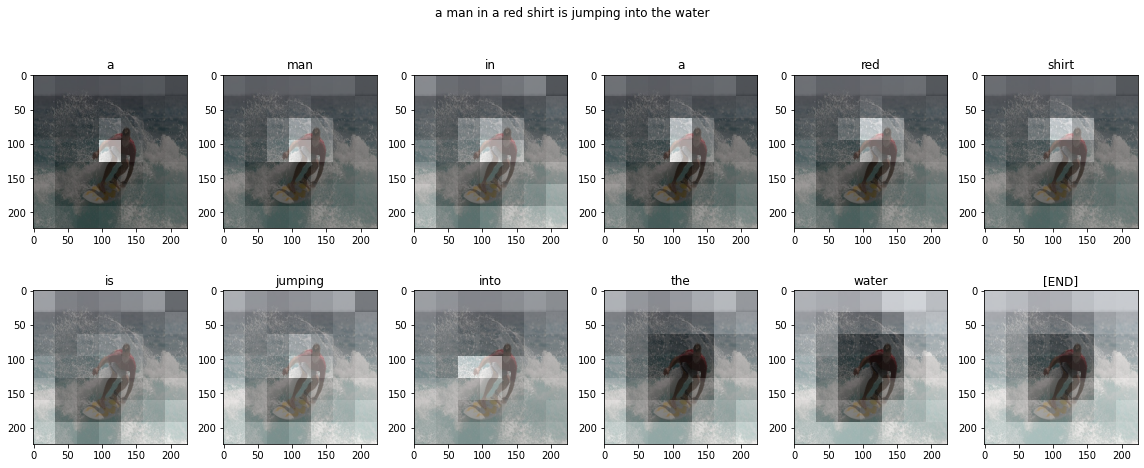

In [ ]:
run_and_show_attention(model, image)

<h4 align="justify">
Ξανατρέχουμε το μοντέλο μας σε άλλη εικόνα:
</h4>

image_dir/_415805544.jpg


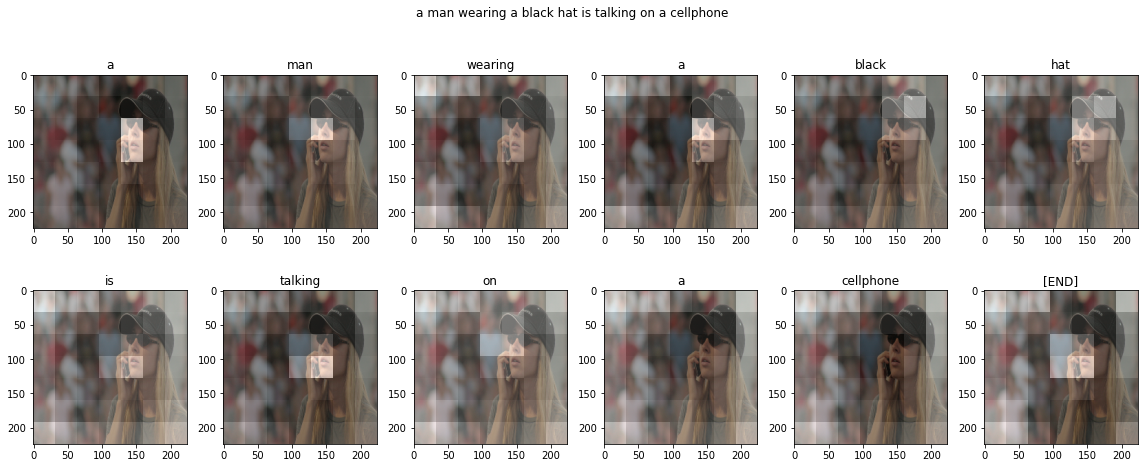

In [ ]:
image_url = "image_dir/" + test_files[170]
print(image_url)
#image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_url)

run_and_show_attention(model, image)

In [ ]:
print (cap_dict[test_files[170]])

['A young blond woman wearing a hat and sunglasses talks on her cellphone .', 'woman with dark glasses and ball cap talking on a cellphone', 'A blond woman in sunglasses and hat talks on a cellphone .', 'a lady with a baseball cap on talking on he cellphone', 'A woman talks on the phone at a stadium .']


### Αξιολόγηση της ποιότητας του captioning (BLEU)

<h4 align="justify">Υλοποιούμε παρακάτω τις συναρτήσεις για τον υπολογισμό των sentence_bleu και corpus_blue και τυπώνουμε τα αποτελέσματα αυτών: </h4>

In [ ]:
import nltk
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
def sent_bleu(img):
  references = cap_dict[img]
  image = load_image('image_dir/'+img)
  hypothesis = (model.beam_gen(image, beam_size=5)).split()
  ref_fin = []
  for ref in references:
    ref_fin.append(ref.split()) 
  score = nltk.translate.bleu_score.sentence_bleu(ref_fin, hypothesis, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)
  print('The sentence BLEU score is: ', score)

sent_bleu(test_files[170])

The sentence BLEU score is:  0.3811962660191964


In [ ]:
def cop_bleu():
  ref_total = []
  hyp_fin = []
  for i in range(1000):
    ref_fin = []
    references = cap_dict[test_files[i]]
    image = load_image('image_dir/'+test_files[i])
    hypothesis = (model.beam_gen(image, beam_size=5)).split()
    for ref in references:
      ref_fin.append(ref.split())
    ref_total.append(ref_fin)
    hyp_fin.append(hypothesis) 
  score = nltk.translate.bleu_score.corpus_bleu(ref_total, hyp_fin, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)
  print('The corpus BLEU score for 1000 images is: ', score)

cop_bleu()

      

The corpus BLEU score for 1000 images is:  0.22805896620196922


<h4 align="justify"> Παρατηρούμε σαφή βελτίωση των αποτελεσμάτων στο δεύτερο μέρος, όπου και αλλάξαμε μοντέλο, κάναμε fine tuning και χρησιμοποιήσαμε beam search αντί της παραμέτρου θερμοκρασίας. Ειδικότερα: </h4>

<div align="center">
<table>
  <tr>
    <th>Παραδοτέο</th>
    <th>Sentence Bleu</th>
    <th>Corpus Bleu</th>
  </tr>
  <tr>
    <td>Πρώτο (χωρίς βελτιώσεις) </td>
    <td> 3.99% </td>
    <td> 18.04% </td>
  </tr>
  <tr>
    <td>Δεύτερο (με βελτιώσεις) </td>
    <td> 38.12% </td>
    <td> 22.81% </td>
  </tr>
</table>
</div>